In [1]:
import numpy as np
#import mkl
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import timeit
from rpl import RadarSignalProcessing
import sys
sys.path.append('C:\\Users\\nxg05733\\RADIal\\DBReader')
from DBReader.DBReader import SyncReader

c:\Users\nxg05733\Panoptic-lifting\panoptic-lifting-main\panoptic-lifting-main\panoptic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load the dataset

In [3]:
sys.path.append('D:\DSAI-22-24\KTH-Year2\Thesis\RADIal')
root_folder ="E:\\RADIal\\RECORD@2020-11-21_11.54.31"
#db = SyncReader(root_folder,tolerance=40000,offset_radar = -180000,offset_scala = -40000)
db = SyncReader(root_folder,tolerance=20000,)

-------------------------------------------------------------------------
- Sensors available:
-     camera
-     can
-     gps
-     radar_ch0
-     radar_ch1
-     radar_ch2
-     radar_ch3
-     scala
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  21.664050235478808 %
Total corrupted frames:  3.6891679748822606 %


In [4]:
sample = db.GetSensorData(60)
sample.keys()

dict_keys(['radar_ch3', 'radar_ch0', 'radar_ch1', 'radar_ch2', 'camera', 'can', 'scala'])

In [9]:
sample['scala']['data']

array([[ 0.03258839,  0.07299781, -0.00305219, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01222488,  0.02738366, -0.00082927, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01222776,  0.02739011, -0.00051363, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.04101115, -0.09099369,  0.00618325, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [7]:
sample['camera']['data'].shape

(1080, 1920, 3)

In [8]:
1080*1920

2073600

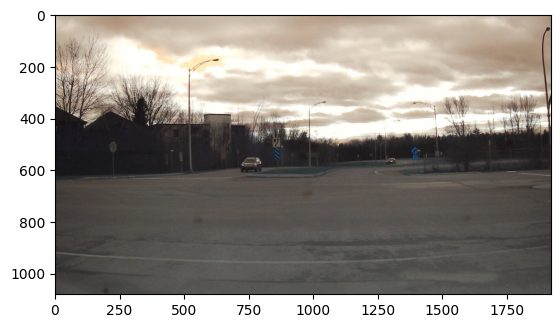

In [15]:
sample = db.GetSensorData(60)
plt.imshow(sample['camera']['data'])

## 2. RadarSignalProcessing to compute Point Cloud 

In [4]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='PC')

CPU will be used to execute the processing


In [5]:
%time pc=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: user 1.17 s, sys: 100 ms, total: 1.28 s
Wall time: 258 ms


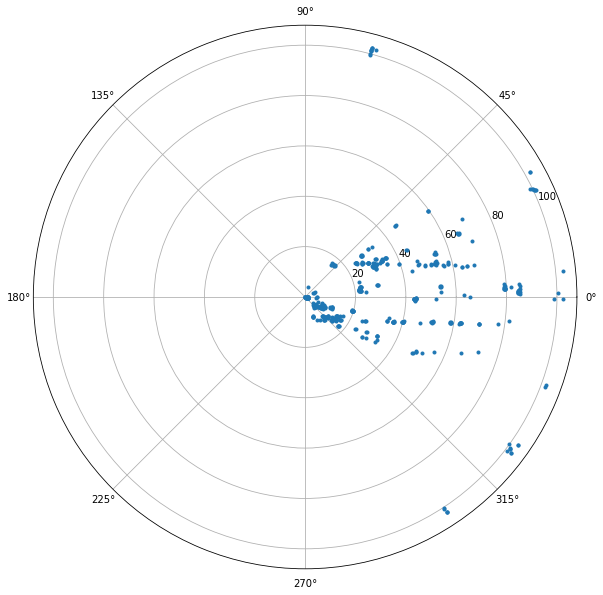

In [6]:
# PC = [Range,Doppler,Azimuth,Elevation]
Az = pc[:,2]
R = pc[:,0]
plt.figure(figsize=(10,10))
plt.polar(Az,R,'.')

## 3. RadarSignalProcessing to compute Doppler Spectrums

In [26]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RD')

CPU will be used to execute the processing


In [27]:
%time rd=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: total: 531 ms
Wall time: 284 ms


(512, 256, 16) It has 16 channels, one for each Rx antenna


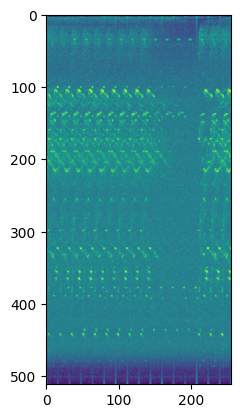

In [28]:
print(rd.shape,'It has 16 channels, one for each Rx antenna')
plt.imshow(np.log10(np.sum(np.abs(rd),axis=2)))

## 4. RadarSignalProcessing to compute Range-Azimuth map

### 4.1 Using CuPy

In [48]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='PyTorch')

PyTorch on GPU will be used to execute the processing


In [51]:
%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: total: 1.8 s
Wall time: 1.62 s


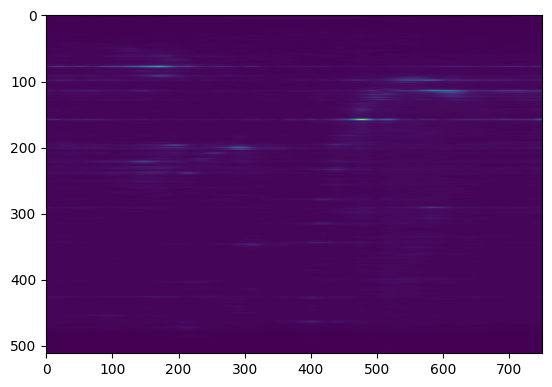

In [50]:
plt.imshow(ra)

### 4.2 Using PyTorch

In [33]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cuda',lib='PyTorch')

PyTorch on GPU will be used to execute the processing


In [34]:
%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: total: 2.47 s
Wall time: 2.21 s


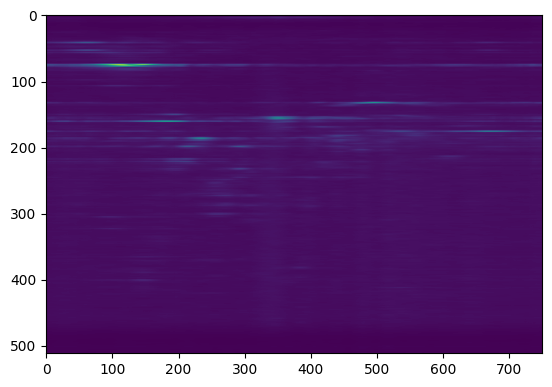

In [35]:
plt.imshow(ra)

### 4.3 Using CPU

In [16]:
RSP = RadarSignalProcessing('CalibrationTable.npy',method='RA',device='cpu')

In [17]:
%time ra=RSP.run(sample['radar_ch0']['data'],sample['radar_ch1']['data'],sample['radar_ch2']['data'],sample['radar_ch3']['data'])

CPU times: total: 8.44 s
Wall time: 2.85 s


In [36]:
# function to measure SSIM
from skimage.metrics import structural_similarity as ssim

def measure_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min())

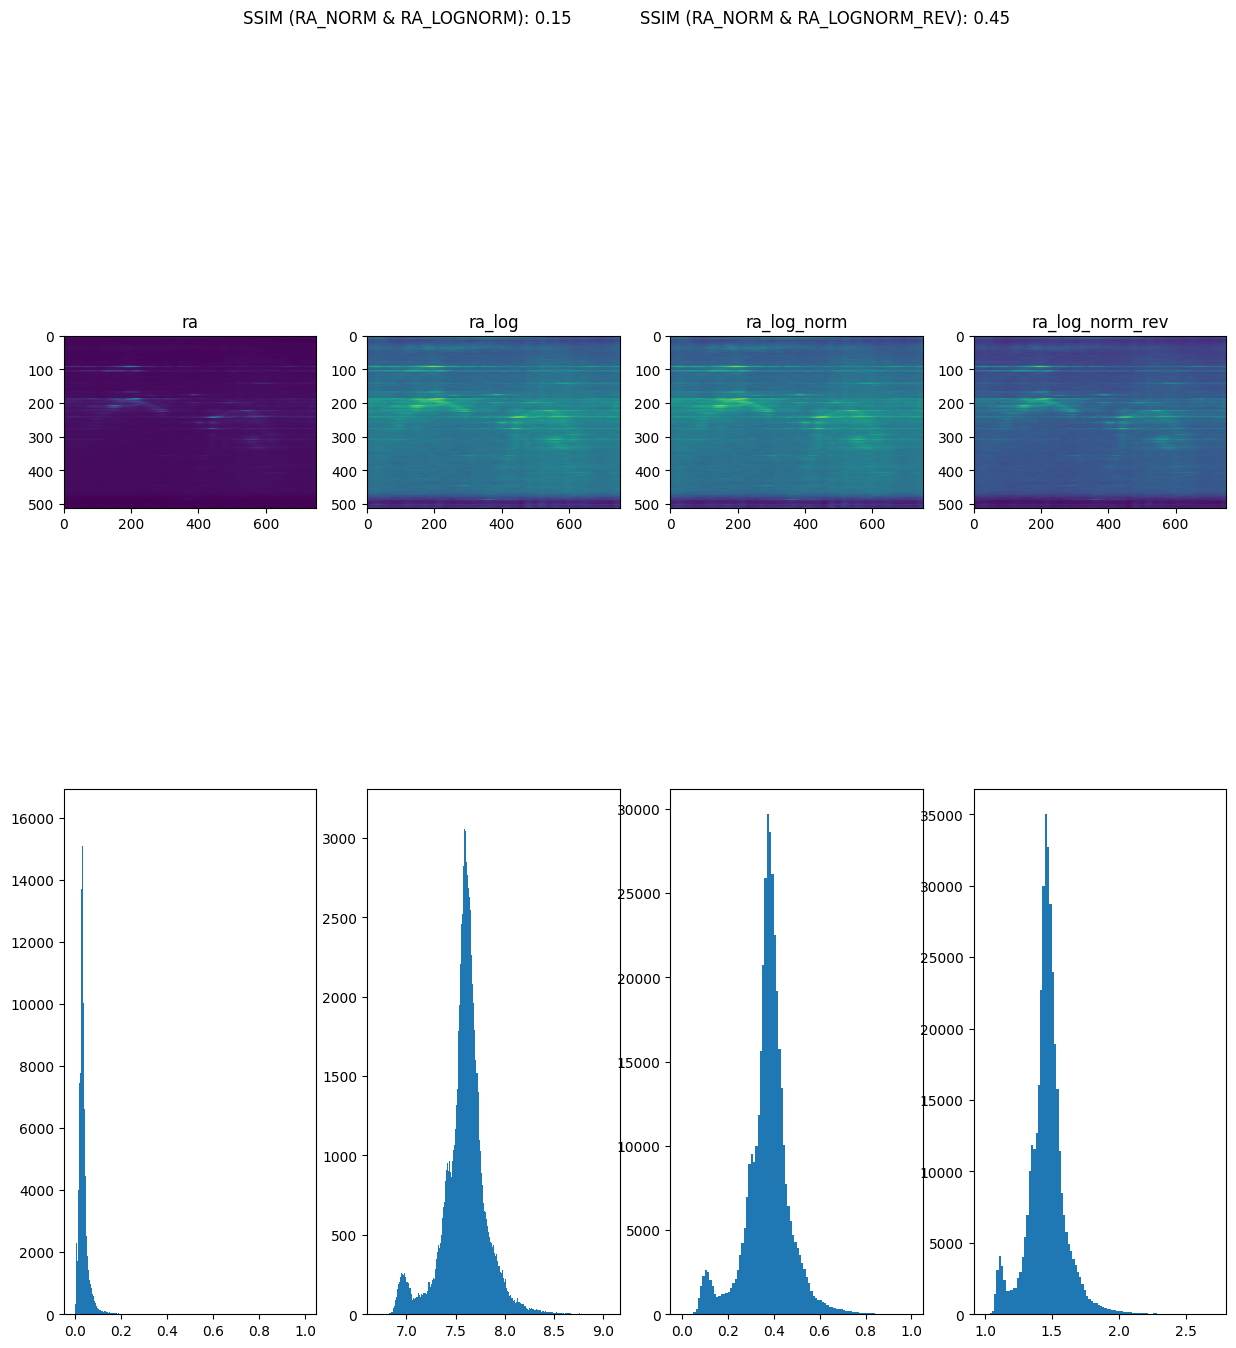

In [38]:
# log norm ra
ra_log = np.log10(np.abs(ra))

# normalize ra
ra_norm = (ra - np.min(ra))/(np.max(ra)-np.min(ra))

# normalize ra_log_norm
ra_log_norm = (ra_log - np.min(ra_log))/(np.max(ra_log)-np.min(ra_log))

ra_log_norm_rev = np.exp(ra_log_norm)
# plot 3 images and their histograms
fig, ax = plt.subplots(2,4,figsize=(15,15))
ax[0,0].imshow(ra_norm)
ax[0,0].set_title('ra')
ax[0,1].imshow(ra_log)
ax[0,1].set_title('ra_log')
ax[0,2].imshow(ra_log_norm)
ax[0,2].set_title('ra_log_norm')
ax[0,3].imshow(ra_log_norm_rev)
ax[0,3].set_title('ra_log_norm_rev')
ax[1,0].hist(ra_norm.flatten(),bins=1000)
ax[1,1].hist(ra_log.flatten(),bins=1000)
ax[1,2].hist(ra_log_norm.flatten(),bins=100)
ax[1,3].hist(ra_log_norm_rev.flatten(),bins=100)

plt.suptitle(f"SSIM (RA_NORM & RA_LOGNORM): {measure_ssim(ra_norm, ra_log_norm):.2f}\
             SSIM (RA_NORM & RA_LOGNORM_REV): {measure_ssim(ra_log_norm_rev, ra_log_norm):.2f}")
plt.show()

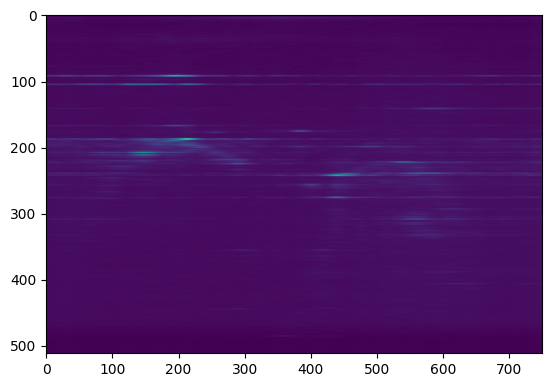

In [25]:
import matplotlib
plt.imshow(ra, )

Flip and Rename axis of image


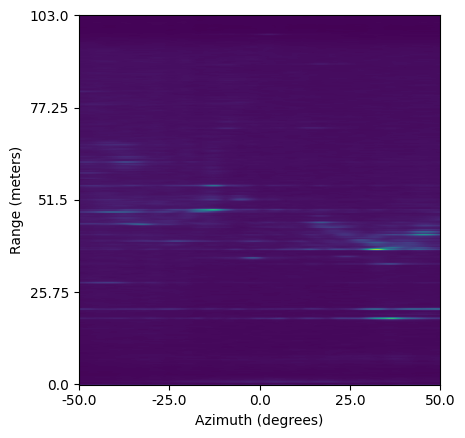

In [19]:
# Step 1: Flip the image 180 degrees
import imutils
flipped_image = imutils.rotate(ra, 180)
# Step 2: Reduce the FOV to 100 degrees
flipped_image= flipped_image[:,125:(flipped_image.shape[1]-125)]
plt.imshow(flipped_image)

""" 
""" # Step 2: Rescale the x and y axis to match -75 to 75 degrees (Azimuth) and 0 to 103 meters (Range)
x_labels = np.linspace(-50, 50, num=5)
y_labels = np.linspace(103,0, num=5)
xtik_loc = np.linspace(0, flipped_image.shape[1]-1, num=len(x_labels))
ytik_loc = np.linspace(0, flipped_image.shape[0]-1, num=len(y_labels))
plt.xticks( ticks=xtik_loc, labels=x_labels)
plt.yticks(ticks= ytik_loc, labels=y_labels)

plt.xlabel('Azimuth (degrees)')
plt.ylabel('Range (meters)')

# Step 3: Reduce the FOV to 100 degrees
#Normalize the image
flipped_image = flipped_image - np.min(flipped_image)
flipped_image = flipped_image / np.max(flipped_image)
plt.imshow(flipped_image)


Convert Polar to Cart

In [93]:
import cv2
azimuth_table = np.load("C:\\Users\\nxg05733\\RADIal\\RADIal\\SignalProcessing\\CalibrationTable.npy", allow_pickle=True).item()['Azimuth_table']
def polar2cart(image):
    center = (image.shape[0], int(image.shape[1]/2))
    x_cart =[]
    y_cart = []
    values= []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r= i
            theta = 90 - azimuth_table[j]
            x = r * np.cos(np.radians(theta))
            y = r * np.sin(np.radians(theta))
            x_cart.append(x)
            y_cart.append(y)
            values.append(image[i,j])
    

    return x_cart, y_cart, values

x_cart, y_cart, values = polar2cart(flipped_image)

In [88]:
x_cart, y_cart, values = polar2cart(ra)

In [83]:
np.array(y_cart).max()

511.0

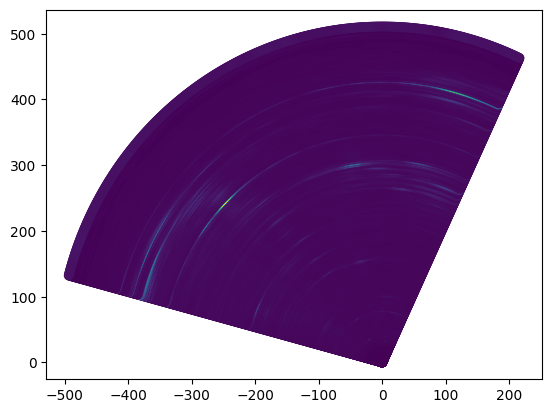

In [94]:
#scatter plot x_cart, y_cart, values
plt.scatter(x_cart, y_cart, c=values,)

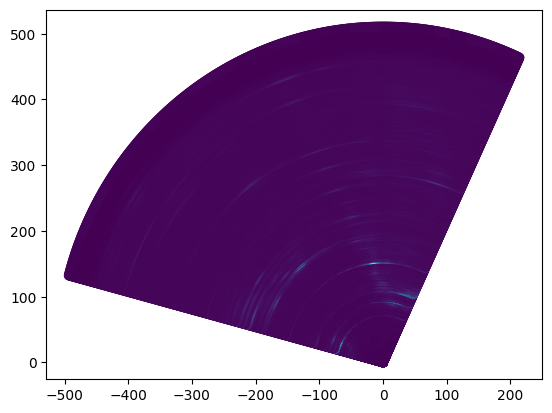

In [92]:
plt.scatter(x_cart, y_cart, c=values,)